# [DeepSphere]: a spherical convolutional neural network
[DeepSphere]: https://github.com/SwissDataScienceCenter/DeepSphere

[Nathanaël Perraudin](https://perraudin.info), [Michaël Defferrard](http://deff.ch), Tomasz Kacprzak, Raphael Sgier

# Demo: part of sphere classification

This demo uses the whole datataset, smoothing, and the addition of noise.

**You need a private dataset to execute this notebook.**
See the [README](https://github.com/SwissDataScienceCenter/DeepSphere/tree/master#reproducing-the-results-of-the-paper).
But you can use it with your own data.

### 0.1 Load packages

In [94]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import shutil
import sys

# Run on first GPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append('../..')

# To get the CUDA profiler (do it on the CLI before starting jupyter):
# export LD_LIBRARY_PATH=/usr/local/cuda-9.0/extras/CUPTI/lib64

import numpy as np
import matplotlib.pyplot as plt

from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset

In [3]:
plt.rcParams['figure.figsize'] = (17, 5)

### 0.2 Definition of the parameters

#### A) Non tunable parameters
These parameters are fixed or the preprocessing script has to be modified.

In [4]:
Nside = 1024
sigma = 3
data_path = '/mnt/scratch/lts2/mdeff/deepsphere/data/same_psd/'
# data_path = 'data/same_psd/'

#### B) Tunable parameters
These parameters can be changed.

We choose to work in the noiseless setting by setting `sigma_noise = 0`. This allows this notebook to run an acceptable time. In the noisy case, the training of the network needs considerably more iterations.

In [5]:
order = 1  # 1,2,4,8 correspond to 12,48,192,768 parts of the sphere.
sigma_noise = 2  # Amount of noise for the experiment

# 1 Data preparation

### 1.1 Data download
Set `download` to `True` to download the dataset from zenodo

In [6]:
download = False
if download:
    %run -i 'download.py'

### 1.2 Data preprocessing
Apply the preprocessing steps.
1. Remove the mean of the maps
2. Smooth with a radius of 3 arcmin. (`sigma` parameter)

Set `preprocess` to `True` to execute the preprocessing script.

In [6]:
preprocess = False
if preprocess:
    %run -i 'data_preprocess.py'

Let us display the resulting PSDs of the preprocessed data. We pre-computed the PSDs for faster execution.

compute = False
if compute:
    psd = experiment_helper.psd
    data_path = 'data/same_psd/'
    ds1 = np.load(data_path+'smoothed_class1_sigma{}.npz'.format(sigma))['arr_0']
    ds2 = np.load(data_path+'smoothed_class2_sigma{}.npz'.format(sigma))['arr_0']
    psds_img1 = [psd(img) for img in ds1]
    psds_img2 = [psd(img) for img in ds2]
    np.savez('results/psd_data_sigma{}'.format(sigma), psd_class1=psds_img1, psd_class2=psds_img2)
else:
    psds_img1 = np.load('results/psd_data_sigma{}.npz'.format(sigma))['psd_class1']
    psds_img2 = np.load('results/psd_data_sigma{}.npz'.format(sigma))['psd_class2']

The PSD of the two classes is almost indistinguishable. 

Spoiler Alert! This is the reason why PSD features are not good enough to classify the data.

ell = np.arange(psds_img1.shape[1])

plot.plot_with_std(ell,np.stack(psds_img1)*ell*(ell+1), label='class 1, $\Omega_m=0.31$, $\sigma_8=0.82$, $h=0.7$', color='r')
plot.plot_with_std(ell,np.stack(psds_img2)*ell*(ell+1), label='class 2, $\Omega_m=0.26$, $\sigma_8=0.91$, $h=0.7$', color='b')
plt.legend(fontsize=16);
plt.xlim([11, np.max(ell)])
plt.ylim([1e-6, 5e-4])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\ell$: spherical harmonic index', fontsize=18)
plt.ylabel('$C_\ell \cdot \ell \cdot (\ell+1)$', fontsize=18)
plt.title('Power Spectrum Density, 3-arcmin smoothing, noiseless, Nside=1024', fontsize=18);


### 1.2 Data loading
The following functions will
1. Load the preprocessed data
2. Create samples by dividing the complete spheres in patches (based on healpix sampling). See the function `hp_split` of `experiment_helper.py` for more specific informations.

The function that load the testing data will additionally add the noise to the sample.

In [149]:
x_raw_train, labels_raw_train, x_raw_std = experiment_helper.get_training_data(sigma, order, data_path=data_path)

In [7]:
x_raw_test, labels_test, _ = experiment_helper.get_testing_data(sigma, order, sigma_noise, x_raw_std, data_path=data_path[:-9])

* Non normalized Laplacian
* degree hist
* less neighbours 20

In [30]:
Gold = utils.healpix_graph(1024, True, 'normalized', indexes=utils.nside2indexes([1024], 1)[0], new=False)
Gnew = utils.healpix_graph(1024, True, 'normalized', indexes=utils.nside2indexes([1024], 1)[0], new=True)

Text(0.5,1,'weighted degree distribution: DeepSphere V1')

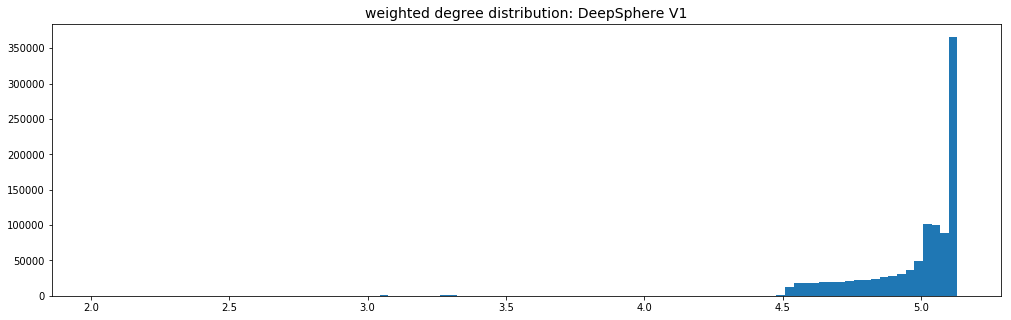

In [9]:
plt.hist(Gold.dw, bins=100)
plt.title('weighted degree distribution: DeepSphere V1', fontsize=14)

Text(0.5,1,'weighted degree distribution: DeepSphere V2\nneighbors=50')

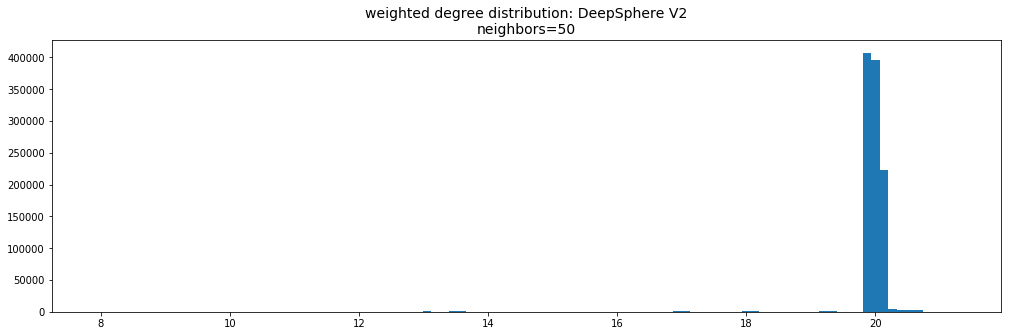

In [10]:
plt.hist(Gnew.dw, bins=100)
plt.title('weighted degree distribution: DeepSphere V2\nneighbors=50', fontsize=14)

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


([<matplotlib.axis.XTick at 0x7f8116e2b320>,
 <a list of 3 Text xticklabel objects>)

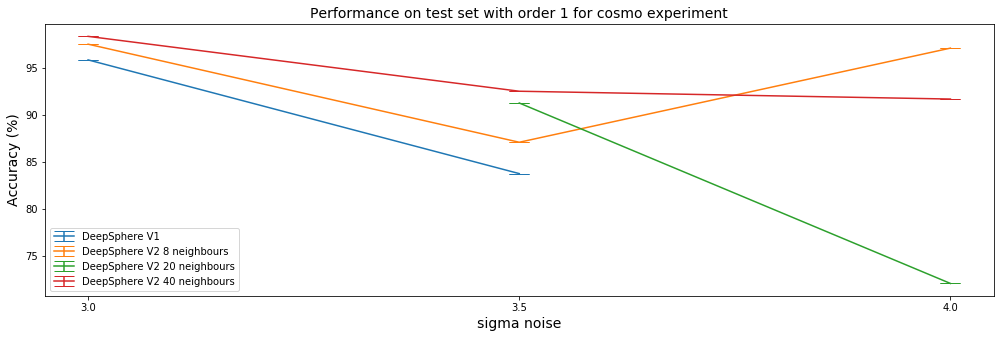

In [93]:
batch_size = 8
batch_time_V1 = [1.49936, 1.48389, 1.53598, 1.55628, 1.474281]
# batch_time_V2_50 = [3.4973, 3.5826, 3.36076]
batch_time_V2_40 = [2.95925, 2.86425, 2.87896]
batch_time_V2_20 = [2.09028, 2.04751, 1.96164, 2.00741, 1.94831, 1.93147716, 1.99608524]
batch_time_V2_8  = [1.47995, 1.48571, 1.48775]
training_time = {"V1": "187 1h45",
                 "V1 CNN": "186 1h45"
#                  "V2 50": "3h10",
                 "V2 40": "363  3h45",
                 "V2 20": "250  2h30",
                 "V2 8":  "185 1h45",}
noise_ = [3, 3.5, 4]# [2, 3, 4, 6, 8]
# new_graph_res = [99.17, np.nan, 94.58, 74.58, 68.33]
new40_graph_res = [[98.33, 92.5, 91.67]]#[98.33, 96.67, 94.17], [np.nan, np.nan, 91.67]]
new20_graph_res = [[np.nan, 91.25, 72.08]]#[95.42, 98.34, 81.67], [np.nan, 91.25, 72.08]]
#                     [[99.58, 99.58, 75.0, 67.92, 66.25], [99.58, np.nan,72.5,66.67,66.25], #[np.nan, np.nan, 71.25, 62.08]
#                    [99.58, np.nan,81.67,54.17,57.5], [100, np.nan, 80.42, 74.58,68.34]]
new8_graph_res = [[97.5, 87.08, 97.08]]#[97.5, 90, 73.34], [94.17, 87.08, 81.67]]
#                 [[99.17, 90.0, 90.42, 62.92, 64.12],[99.58, 98.75, 83.33, 73.75, 63.75], [100, np.nan, 68.34, 69.17, 57.08], 
#                   [100, np.nan, 82.92, 62.92, 57.5]]
old_graph_res = [[95.83, 83.75, np.nan]]#[95.83, 91.25, 71.25], [np.nan, 83.75, np.nan]]
#                 [[99.17, 98.34, 94.58, 61.25, 57.5], [np.nan, np.nan,79.17,62.08,62.08], # ,[99.17, 93.75, 70.42, 70.42]
#                  [100, np.nan, 83.75, 57.5, 61.25], [100, np.nan, 94.58, 75.0, 60.0], [100, np.nan, 72.67, 62.08, np.nan]]
plt.errorbar(noise_, np.nanmean(old_graph_res, axis=0), yerr=np.nanstd(old_graph_res, axis=0), capsize=10,label='DeepSphere V1')
plt.errorbar(noise_, np.nanmean(new8_graph_res, axis=0), yerr=np.nanstd(new8_graph_res, axis=0), capsize=10, label='DeepSphere V2 8 neighbours')
plt.errorbar(noise_, np.nanmean(new20_graph_res, axis=0), yerr=np.nanstd(new20_graph_res, axis=0), capsize=10, label='DeepSphere V2 20 neighbours')
plt.errorbar(noise_, np.nanmean(new40_graph_res, axis=0), yerr=np.nanstd(new40_graph_res, axis=0), capsize=10, label='DeepSphere V2 40 neighbours')
# plt.errorbar(noise_, new_graph_res, yerr=[0, 0, 0, 0, 0], label='DeepSphere V2 50 neighbours')
plt.legend()
plt.xlabel('sigma noise', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Performance on test set with order 1 for cosmo experiment', fontsize=14)
# plt.xlim([2.8,4.2])
plt.xticks([3,3.5,4])

# 2 Solve the problem using histogram features and an SVM classifier

### 2.1 Features compuation and dataset creation
The following function prepare the features for the SVM classifier.
1. It splits the training data into a training and a validation set.
2. It augments the training set by adding different realization of random noise to the sample
3. It computes the histogram features for the training, validation and testing set.
4. It normalizes the features in order for them to have a mean of 0 and a variance of 1.

The features are computed using the function `histogram` of `experiment_helper.py`.

We use 10 different noise realization by setting `augmentation=10` in order to increase the number of training sample.

ret = experiment_helper.data_preprossing(x_raw_train, labels_raw_train, x_raw_test, sigma_noise, feature_type='histogram', augmentation=10)
features_train, labels_train, features_validation, labels_validation, features_test = ret 

### 2.2  Classification using SVM
Let us test classify our data using an SVM classifier.

error_train, error_validation, C = experiment_helper.err_svc_linear(features_train, labels_train, features_validation, labels_validation)


print('The validation error is {}%'.format(error_validation * 100), flush=True)
print('The Training error is {}%'.format(error_train * 100), flush=True)


We now compute the error on the testing set. To avoid complexity, we do a small mistake that advantage the SVM classifer: we do cross-validation on the testing set.

While this is wrong, the spherical CNN still clearly outperform the SVM classifier.

_, error_test = experiment_helper.err_svc_linear_single(C, features_train, labels_train, features_test, labels_test)

print('The testing error is {}%'.format(error_test * 100), flush=True)

### 2.3 Histogram features visualization

To get a grasp of what is happening, let us plot the histogram of the data.

cmin = np.min(x_raw_train)
cmax = np.max(x_raw_train)
bins = 100
x = np.linspace(cmin,cmax,bins)

fig, axes = plt.subplots(1, 2)
x_hist = experiment_helper.histogram(x_raw_train, cmin, cmax)
plot.plot_with_std(x, x_hist[labels_raw_train==0], color='b', label='class 1', ax=axes[0])
plot.plot_with_std(x, x_hist[labels_raw_train==1], color='r', label='class 2', ax=axes[0])
axes[0].legend()
axes[0].set_title('Histogram - Noiselss case');

if sigma_noise:
    # Updating cmin and cmax does not really affect the features. 
    # We keep the same as in the noisless case in order to have the same x axis.
    x_hist = experiment_helper.histogram(x_raw_train+sigma_noise*np.random.randn(*x_raw_train.shape), cmin, cmax)
    plot.plot_with_std(x, x_hist[labels_raw_train==0], color='b', label='class 1', ax=axes[1])
    plot.plot_with_std(x, x_hist[labels_raw_train==1], color='r', label='class 2', ax=axes[1])
    axes[1].legend()
    axes[1].set_title('Histogram-  Noisy case');


These histogram are normalized in order to get the final features

ax = plot.plot_with_std(features_train[labels_train==0], color='b', label='class 1')
ax = plot.plot_with_std(features_train[labels_train==1], color='r', label='class 2', ax=ax)
ax.legend()
ax.set_title('Histogram features');

# ax = plot.plot_with_std(features_validation[labels_validation==0,:80], color='b', label='class 1')
# ax = plot.plot_with_std(features_validation[labels_validation==1,:80], color='r', label='class 2', ax=ax)
# ax.legend()
# ax.set_title('Histogram features - Validation set');

# ax = plot.plot_with_std(features_test[labels_test==0,:80], color='b', label='class 1')
# ax = plot.plot_with_std(features_test[labels_test==1,:80], color='r', label='class 2', ax=ax)
# ax.legend()
# ax.set_title('Histogram features - Test set');

# 3 Solve the problem using PSD features and an SVM classifier
Solving the problem with PSD features is very similar than solving it with histogram features. Hence we are not describing each step.

The computation of the PSD features is actually very expensive. Since the classifier will also fail miserably, you may just want to not exectute this part of the notebook. In order to reduce the amount of PSD to be computed, we disable the dataset augementation by setting `augmentation=1`. Nevertheless, we use augmentation for the results in the paper.

ret = experiment_helper.data_preprossing(x_raw_train, labels_raw_train, x_raw_test, sigma_noise, feature_type='psd', augmentation=1)
features_train, labels_train, features_validation, labels_validation, features_test = ret 

error_train, error_validation, C = experiment_helper.err_svc_linear(features_train, labels_train, features_validation, labels_validation)
print('The validation error is {}%'.format(error_validation * 100), flush=True)
print('The Training error is {}%'.format(error_train * 100), flush=True)

_, error_test = experiment_helper.err_svc_linear_single(C, features_train, labels_train, features_test, labels_test)
print('The testing error is {}%'.format(error_test * 100), flush=True)

### 2.3 PSD features visualization

To get a grasp of what is happening, let us plot the psd features. 

ell = np.arange(features_train.shape[1])
ax = plot.plot_with_std(ell, features_train[labels_train==0], color='b', label='class 1')
ax = plot.plot_with_std(ell, features_train[labels_train==1], color='r', label='class 2', ax=ax)
ax.legend()
ax.set_title('PSD features');
# plt.xscale('log')

# ell = np.arange(features_train.shape[1])
# ax = plot.plot_with_std(ell, features_validation[labels_validation==0], color='b', label='class 1')
# ax = plot.plot_with_std(ell, features_validation[labels_validation==1], color='r', label='class 2', ax=ax)
# ax.legend()
# ax.set_title('PSD features - validation dataset');
# # plt.xscale('log')

# ell = np.arange(features_train.shape[1])
# ax = plot.plot_with_std(ell, features_test[labels_test==0], color='b', label='class 1')
# ax = plot.plot_with_std(ell, features_test[labels_test==1], color='r', label='class 2', ax=ax)
# ax.legend()
# ax.set_title('PSD features - testing dataset');
# # plt.xscale('log')

# 4 Classification using Deep Sphere

Let us now classify our data using a spherical convolutional neural network.

### 4.1 Preparation of the dataset
Let us create the datafor the spherical neural network. It is simply the raw data.

In [97]:
ret = experiment_helper.data_preprossing(x_raw_train, labels_raw_train, x_raw_test, sigma_noise, feature_type=None)
features_train, labels_train, features_validation, labels_validation, features_test = ret

Class 1 VS class 2
  Training set: 195 / 189
  Validation set: 45 / 51


The spherical neural network will uses a Dataset object that need to be initialized. The object `LabeledDatasetWithNoise` will add noise to the raw data at the time of training. It will slowly increase the amount of noise during `nit` iteration.

In [155]:
training = LabeledDatasetWithNoise(features_train, labels_train, end_level=sigma_noise)
validation = LabeledDataset(features_validation, labels_validation)

### 4.2 Building the Network

We now create our spherical neural network. We use one architecture, a fully convolutional architecture (see the exact parameters in `hyperparameters.py`), for all the problems (that is for all configurations of `order` and `sigma_noise`. A smaller `order` means more pixels per sample, that is more data for a prediction. It translates to higher accuracy as the network is more confident about its prediction (as they are averaged across spatial locations).

For the paper, we selected a conservative set of parameters that were providing good results across the board. To train faster, diminish `num_epochs`, or interrupt training whenever you get bored. To reproduce all the results from the paper, the easiest is to run the `experiments_deepsphere.py` script.

In [151]:
ntype = 'FCN'
EXP_NAME = 'oldgraph_{}sides_{:0.1f}noise_{}order_{}sigma_{}'.format(Nside, sigma_noise, order, sigma, ntype)

In [13]:
# Cleanup before running again.
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

In [ ]:
def get_params(ntrain, EXP_NAME, order, Nside, architecture="FCN", verbose=True):
    """Parameters for the cgcnn and cnn2d defined in deepsphere/models.py"""

    n_classes = 2

    params = dict()
    params['dir_name'] = EXP_NAME

    # Types of layers.
    params['conv'] = 'chebyshev5'  # Graph convolution: chebyshev5 or monomials.
    params['pool'] = 'max'  # Pooling: max or average.
    params['activation'] = 'relu'  # Non-linearity: relu, elu, leaky_relu, softmax, tanh, etc.
    params['statistics'] = 'mean'  # Statistics (for invariance): None, mean, var, meanvar, hist.

    # Architecture.
    params['F'] = [16, 32, 64, 64, 64, n_classes]  # Graph convolutional layers: number of feature maps.
    params['K'] = [5] * 6  # Polynomial orders.
    params['batch_norm'] = [True] * 6  # Batch normalization.
    params['M'] = []  # Fully connected layers: output dimensionalities.

    # Pooling.
    nsides = [Nside, Nside//2, Nside//4, Nside//8, Nside//16, Nside//32, Nside//32]
    params['nsides'] = nsides
    params['indexes'] = utils.nside2indexes(nsides, order)
#     params['batch_norm_full'] = []

    if architecture == "CNN":
        # Classical convolutional neural network.
        # Replace the last graph convolution and global average pooling by a fully connected layer.
        # That is, change the classifier while keeping the feature extractor.
        params['F'] = params['F'][:-1]
        params['K'] = params['K'][:-1]
        params['batch_norm'] = params['batch_norm'][:-1]
        params['nsides'] = params['nsides'][:-1]
        params['indexes'] = params['indexes'][:-1]
        params['statistics'] = None
        params['M'] = [n_classes]
    elif architecture == "FCN":
        pass
    elif architecture == 'CNN-2d':
        params['F'] = [8, 16, 32, 32, 16]
        params['K'] = [[5, 5]] * 5
        params['p'] = [2, 2, 2, 2, 2]
        params['input_shape'] = [1024//order, 1024//order]
        params['batch_norm'] = params['batch_norm'][:-1]
        params['statistics'] = None
        params['M'] = [n_classes]
        del params['indexes']
        del params['nsides']
        del params['conv']

    elif architecture == 'FCN-2d':
        params['F'] = [8, 16, 32, 32, 16, 2]
        params['K'] = [[5, 5]] * 6
        params['p'] = [2, 2, 2, 2, 2, 1]
        params['input_shape'] = [1024//order, 1024//order]
        del params['indexes']
        del params['nsides']
        del params['conv']
    else:
        raise ValueError('Unknown architecture {}.'.format(architecture))

    # Regularization (to prevent over-fitting).
    params['regularization'] = 0  # Amount of L2 regularization over the weights (will be divided by the number of weights).
    if '2d' in architecture:
        params['regularization'] = 3
    params['dropout'] = 1  # Percentage of neurons to keep.

    # Training.
    params['num_epochs'] = 80  # Number of passes through the training data.
    params['batch_size'] = max(8 * order, 1)    # Constant quantity of information (#pixels) per step (invariant to sample size).

    # Optimization: learning rate schedule and optimizer.
    params['scheduler'] = lambda step: tf.train.exponential_decay(2e-4, step, decay_steps=1, decay_rate=0.999)
    params['optimizer'] = lambda lr: tf.train.AdamOptimizer(lr, beta1=0.9, beta2=0.999, epsilon=1e-8)

    # Number of model evaluations during training (influence training time).
    n_evaluations = 80
    params['eval_frequency'] = int(params['num_epochs'] * ntrain / params['batch_size'] / n_evaluations)

    if verbose:
        print('#sides: {}'.format(nsides))
#         print('#pixels: {}'.format([(nside//order)**2 for nside in nsides]))
        # Number of pixels on the full sphere: 12 * nsides**2.

        print('#samples per batch: {}'.format(params['batch_size']))
#         print('=> #pixels per batch (input): {:,}'.format(params['batch_size']*(Nside//order)**2))
#         print('=> #pixels for training (input): {:,}'.format(params['num_epochs']*ntrain*(Nside//order)**2))

        n_steps = params['num_epochs'] * ntrain // params['batch_size']
        lr = [params['scheduler'](step).eval(session=tf.Session()) for step in [0, n_steps]]
        print('Learning rate will start at {:.1e} and finish at {:.1e}.'.format(*lr))

    return params

In [14]:
params = get_params(training.N, EXP_NAME, order, Nside, ntype)
# params['profile'] = True  # See computation time and memory usage in Tensorboard.
# params['debug'] = True  # Debug the model in Tensorboard.
model = models.deepsphere(**params, new=False)

#sides: [1024, 512, 256, 128, 64, 32, 32]
#samples per batch: 16
Learning rate will start at 2.0e-04 and finish at 4.7e-05.
build laplacian, time:  2.8578410148620605
rescale laplacian, time:  21.98816967010498
build laplacian, time:  22.520158767700195
rescale laplacian, time:  24.76691198348999
build laplacian, time:  24.957375526428223
rescale laplacian, time:  25.347638607025146
build laplacian, time:  25.39183497428894
rescale laplacian, time:  25.51144003868103
build laplacian, time:  25.522844791412354
rescale laplacian, time:  25.560038328170776
build laplacian, time:  25.565006256103516
rescale laplacian, time:  25.576037883758545
NN architecture
  input: M_0 = 1048576
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1048576 * 16 / 4 = 4194304
    weights: F_0 * F_1 * K_1 = 1 * 16 * 5 = 80
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 262144 * 32 / 4 = 2097152
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    

### 4.3 Find an optimal learning rate (optional)

The learning rate is the most important hyper-parameter. A technique to find an optimal value is to visualize the validation loss while increasing the learning rate. One way to define the optimal learning rate is to search for the largest value looking for which the validation loss still decreases.

In [15]:
# backup = params.copy()
# 
# params, learning_rate = utils.test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)
# 
# shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
# shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)
# 
# model = models.deepsphere(**params)
# _, loss_validation, _, _ = model.fit(training, validation)
# 
# params.update(backup)
#
# plt.semilogx(learning_rate, loss_validation, '.-')

### 4.4 Training the network

Here are a few remarks.
* The model will create tensorboard summaries in the `summaries` folder. Start tensorboard with `cd summaries` then `tensorboard --logdir .`, and open <http://localhost:6006> in a browser tab to visualize training progress and statistics about the learned parameters. You can debug the model by setting `params['debug'] = True` and launching tensorboard with `tensorboard --logdir . --debugger_port 6064`.
* You probably need a GPU to train the model in an acceptable amount of time.
* You will get slightly different results every time the network is trained.

In [ ]:
accuracy_validation, loss_validation, loss_training, t_step, t_batch = model.fit(training, validation)

training from scratch
step 14 / 1440 (epoch 0.58 / 60):
  learning_rate = 1.97e-04, training mAP = 0.00, training loss = 6.92e-01


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 53.12 (51 / 96), f1 (weighted): 36.86, loss: 1.16e+00
  CPU time: 57s, wall time: 70s, perf_time_load: 1.671s, perf_time: 2.775s
step 28 / 1440 (epoch 1.17 / 60):
  learning_rate = 1.95e-04, training mAP = 0.00, training loss = 5.98e-01
  validation accuracy: 53.12 (51 / 96), f1 (weighted): 36.86, loss: 1.04e+00
  CPU time: 97s, wall time: 125s, perf_time_load: 1.672s, perf_time: 2.771s
step 42 / 1440 (epoch 1.75 / 60):
  learning_rate = 1.92e-04, training mAP = 0.00, training loss = 6.37e-01
  validation accuracy: 53.12 (51 / 96), f1 (weighted): 36.86, loss: 1.17e+00
  CPU time: 130s, wall time: 173s, perf_time_load: 1.696s, perf_time: 2.683s
step 56 / 1440 (epoch 2.33 / 60):
  learning_rate = 1.89e-04, training mAP = 0.00, training loss = 6.18e-01
  validation accuracy: 53.12 (51 / 96), f1 (weighted): 36.86, loss: 1.30e+00
  CPU time: 164s, wall time: 222s, perf_time_load: 1.726s, perf_time: 2.849s
step 70 / 1440 (epoch 2.92 / 60):
  learning_rate = 1.87e-04, t

In [ ]:
# npix = 12*1024**2
# npixel = [npix/(12*o**2) for o in range(1,5)]
# npixel = [npix]+npixel
# npixel = npixel+[12*32**2]
# DeepSphere = [201, 175, 42, 10.3, 2.8, 1.0]
# plt.loglog(npixel, DeepSphere, label='DeepSphere')
# npixel_cohen = [4*bw**2 for bw in [64, 128, 220]]
# t_cohen = [12, 32, 175]
# t_esteves = [9, 16]
# plt.loglog(npixel_cohen, t_cohen, label='Cohen')
# plt.loglog(npixel_cohen[:-1], t_esteves, label='Esteves')
# plt.legend(fontsize=12)
# plt.xlabel('number of pixels', fontsize=15)
# plt.ylabel('Inference speed [s]', fontsize = 15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.savefig('./figures/cosmo_time.png', bboxes_inches='tight')

We can see below that the classifier does not overfit the training data.

In [ ]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

In [ ]:
error_validation = experiment_helper.model_error(model, features_validation[:,:,np.newaxis], labels_validation)
print('The validation error is {:.2%}'.format(error_validation), flush=True)

In [ ]:
error_test = experiment_helper.model_error(model, features_test[:,:,np.newaxis], labels_test)
print('The testing error is {:.2%}'.format(error_test), flush=True)